In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.reparam import LocScaleReparam
import equinox as eqx
import numpy as np
from typing import NamedTuple
import matplotlib.pyplot as plt
from hiermodelutils import HyperParameter, get_hyperparameter_and_update_model, violinplot_half, RealLineToUnitTransform, UniformToBetaTransform

pprint = eqx.tree_pprint
key, subkey = jax.random.split(jax.random.PRNGKey(0))

/Users/holtw/Documents/mydocs/software/hiermodelutils/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RealLineToUnitTransform

hiermodelutils._distributions.RealLineToUnitTransform

{'bodies': [<matplotlib.collections.PolyCollection at 0x2b261d150>,
  <matplotlib.collections.PolyCollection at 0x2b26462d0>]}

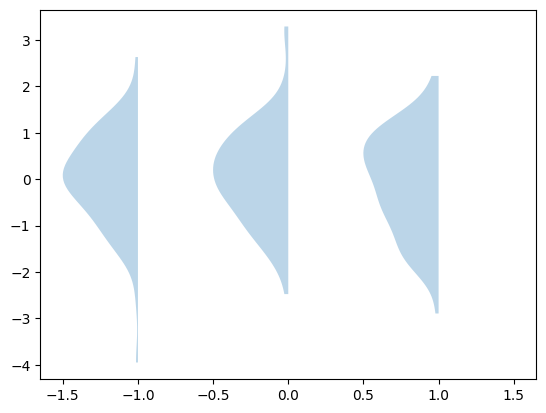

In [16]:
# Check violin plot half function

fig, ax = plt.subplots()
violinplot_half(ax, np.random.randn(100, 3), np.array([-1, 0, 1]), widths=1, showmeans=False, showextrema=False, showmedians=False)

## Model

$$
\begin{gather}
\mu \sim N(0, 100) \\
\tau \sim \text{HalfCauchy}(0, 1) \\
\theta_i \sim N(\mu, \tau^2) \\
y_{ij} \sim N(\theta_i, \sigma^2) \\
\end{gather}
$$

In [2]:
@stochasticmodel("theta")
class Theta(eqx.Module):
    mu: float
    tau: float
    def get_distribution(self):
        return dist.Normal(self.mu, self.tau)

@stochasticmodel("y")
class Y(eqx.Module):
    sigma: float
    def get_distribution(self, theta):
        return dist.Normal(theta, self.sigma)

class LikelihoodModels(NamedTuple):
    theta: eqx.Module
    y: eqx.Module

likelihood_models = LikelihoodModels(theta=Theta(1.0, 1.0), y=Y(1.0))

prior_models = dict(
    mu = Parameter(path=lambda m: m.theta.mu, distribution=dist.Normal(0, 10)),
    tau = Parameter(path=lambda m: m.theta.tau, distribution=dist.HalfNormal(1)),
    sigma = Parameter(path=lambda m: m.y.sigma, distribution=dist.HalfNormal(1))
)

true_prior_models = dict(
    mu = Parameter(path=lambda m: m.theta.mu, distribution=dist.Normal(0.5, 0.5)),
    tau = Parameter(path=lambda m: m.theta.tau, distribution=dist.HalfNormal(0.2)),
    sigma = Parameter(path=lambda m: m.y.sigma, distribution=dist.HalfNormal(0.3))
)

def full_model(likelihood_models, prior_models, data=None):
    if data is None:
        y_obs = None
    else:
        y_obs = data["y"]
    lm = likelihood_models
    lm = draw_sample_and_update_model("mu", lm, prior_models)
    lm = draw_sample_and_update_model("tau", lm, prior_models)
    with numpyro.handlers.reparam(config={"theta": LocScaleReparam(centered=0)}):
        with numpyro.plate("groups", 5):
            theta = lm.theta()
            with numpyro.plate("data", 50):
                y = lm.y(theta, obs=y_obs)
    return locals()

key, subkey = jax.random.split(key)
with numpyro.handlers.seed(rng_seed=subkey):
    tmp = full_model(likelihood_models, prior_models)
    data = dict(y=tmp["y"])
    ground_truth = dict(
        mu = prior_models["mu"].path(tmp["lm"]), 
        tau = prior_models["tau"].path(tmp["lm"]),
        sigma = prior_models["sigma"].path(tmp["lm"]),
        theta = tmp["theta"]
    )

# Create the NUTS sampler
nuts_kernel = NUTS(full_model)

# Run the sampler
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)

key, subkey = jax.random.split(key)
mcmc.run(subkey, likelihood_models, prior_models, data=data)

# Get the samples
samples = mcmc.get_samples()

mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1446.47it/s, 7 steps of size 1.84e-01. acc. prob=0.84] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                 mu     -1.68      0.39     -1.69     -2.27     -1.07    108.22      1.01
                tau      0.77      0.29      0.71      0.36      1.24    158.06      1.00
theta_decentered[0]      0.39      0.51      0.38     -0.42      1.25    125.18      1.00
theta_decentered[1]     -0.71      0.53     -0.68     -1.60      0.13    195.75      1.01
theta_decentered[2]     -1.08      0.59     -1.05     -1.96     -0.11    208.01      1.01
theta_decentered[3]      1.05      0.61      1.05      0.07      1.98    112.82      1.00
theta_decentered[4]      0.24      0.50      0.24     -0.54      1.07    134.78      1.01

Number of divergences: 1


In [3]:
samples["theta"].mean(axis=0)

Array([-1.4207822, -2.172479 , -2.4222944, -0.9754489, -1.5211366],      dtype=float32)

In [4]:
ground_truth

{'mu': Array(-1.6758952, dtype=float32),
 'tau': Array(0.8264735, dtype=float32),
 'sigma': 1.0,
 'theta': Array([-1.2992916 , -2.0699046 , -2.41025   , -0.69256365, -1.6783383 ],      dtype=float32)}

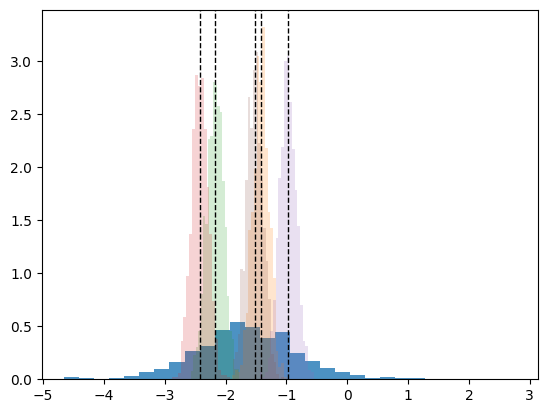

In [5]:
def new_model(likelihood_models, prior_models):
    lm = likelihood_models
    lm = draw_sample_and_update_model("mu", lm, prior_models)
    lm = draw_sample_and_update_model("tau", lm, prior_models)
    return lm.theta(suffix="new")
    # return numpyro.sample("theta_new2", dist.Normal(lm.theta.mu, lm.theta.tau))

new_samples = Predictive(new_model, samples)(subkey, likelihood_models, prior_models)
fig, ax = plt.subplots()
ax.hist(np.array(new_samples["theta_new"]), bins=30, alpha=0.8, density=True);
for i in range(5):
    ax.axvline(samples["theta"][:,i].mean(), color="black", lw=1, linestyle="--")
    ax.hist(samples["theta"][:,i], bins=20, alpha=0.2, density=True);

It works!!